In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        pass

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import os
import re
import random
from pathlib import Path
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import itertools
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as mobilenet_preprocess

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)


2025-10-25 01:13:29.479113: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1761354809.900721      37 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1761354810.034237      37 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Build dataframe of images

In [3]:
base_input = Path('/kaggle/input/breakhis/BreaKHis_v1/histology_slides/breast')
image_paths = sorted([str(p) for p in base_input.rglob('*.png')])
len(image_paths)

7909

# Parse label, magnification, patient id

In [4]:
def parse_breakhis_path(p: str):
    # Example path segment: .../benign/SOB/adenosis/SOB_B_A_14-29960CD/200X/SOB_B_A-14-29960CD-200-012.png
    fname = os.path.basename(p)
    parts = fname.split('_')
    # label: presence of 'B' or 'M' in the filename (second underscore piece in example)
    label_token = parts[1] if len(parts) > 1 else ''
    label = 'benign' if label_token.upper().startswith('B') else 'malignant'
    # magnification is usually parent folder name like '200X', '40X'
    mag = Path(p).parents[0].name  # immediate parent folder like '200X'
    # patient id: third underscore piece typically includes patient and magnification numbers:
    # e.g. 'A-14-29960CD-200-012.png' -> take the chunk before the last two '-' parts
    try:
        third = parts[2]
        patient = third.rsplit('-', 2)[0]  # 'A-14-29960CD'
    except Exception:
        # fallback: attempt regex to capture pattern like A-14-29960CD
        m = re.search(r'([A-Za-z]-\d+-\w+)', fname)
        patient = m.group(1) if m else fname
    return label, mag, patient

rows = []
for p in image_paths:
    label, mag, patient = parse_breakhis_path(p)
    rows.append({'filepath': p, 'label': label, 'mag': mag, 'patient_id': patient})
df = pd.DataFrame(rows)
# Normalize magnification strings (some may be '40X' or '040X')
df['mag'] = df['mag'].str.upper().str.replace(' ', '')
df = df[df['mag'].isin(['40X', '200X'])].reset_index(drop=True)  # keep only 40x and 200x
print("Total images (40x and 200x):", len(df))
df.sample(5)

Total images (40x and 200x): 4008


,filepath,label,mag,patient_id
2580,/kaggle/input/breakhis/BreaKHis_v1/histology_s...,malignant,200X,DC-14-2985
3659,/kaggle/input/breakhis/BreaKHis_v1/histology_s...,malignant,200X,MC-14-19979
897,/kaggle/input/breakhis/BreaKHis_v1/histology_s...,benign,40X,PT-14-22704
2091,/kaggle/input/breakhis/BreaKHis_v1/histology_s...,malignant,40X,DC-14-16875
1044,/kaggle/input/breakhis/BreaKHis_v1/histology_s...,benign,200X,TA-14-16184


# Split by patient into train/val/test


In [5]:
def patient_stratified_split(df, train_frac=0.7, val_frac=0.1, test_frac=0.2, seed=SEED):
    
    assert abs(train_frac + val_frac + test_frac - 1.0) < 1e-6
    splits = {}
    for mag in df['mag'].unique():
        sub = df[df['mag'] == mag].copy()
        benign_patients = sub[sub['label'] == 'benign']['patient_id'].unique().tolist()
        malignant_patients = sub[sub['label'] == 'malignant']['patient_id'].unique().tolist()
        
        # Validate we have enough patients
        if len(benign_patients) < 2 or len(malignant_patients) < 2:
            print(f"Skipping {mag}: insufficient patients per class")
            continue
            
        # Shuffle with same seed for reproducibility
        random.Random(seed).shuffle(benign_patients)
        random.Random(seed).shuffle(malignant_patients)
        
        # Calculate sizes with floor to ensure minimum
        n_benign_train = max(1, int(train_frac * len(benign_patients)))
        n_malignant_train = max(1, int(train_frac * len(malignant_patients)))
        n_benign_val = max(1, int(val_frac * len(benign_patients)))
        n_malignant_val = max(1, int(val_frac * len(malignant_patients)))
        
        # Remainder goes to test
        train_patients = (benign_patients[:n_benign_train] + malignant_patients[:n_malignant_train])
        val_patients = (benign_patients[n_benign_train:n_benign_train + n_benign_val] + 
                       malignant_patients[n_malignant_train:n_malignant_train + n_malignant_val])
        test_patients = (benign_patients[n_benign_train + n_benign_val:] + 
                        malignant_patients[n_malignant_train + n_malignant_val:])
        
        splits[mag] = {
            'train': sub[sub['patient_id'].isin(train_patients)],
            'val': sub[sub['patient_id'].isin(val_patients)],
            'test': sub[sub['patient_id'].isin(test_patients)]
        }
        
        print(f"{mag} - Balanced Splits:")
        for split_name in ['train', 'val', 'test']:
            split_df = splits[mag][split_name]
            benign_count = len(split_df[split_df['label'] == 'benign'])
            malignant_count = len(split_df[split_df['label'] == 'malignant'])
            print(f"   {split_name}: Benign={benign_count}, Malignant={malignant_count}")
    
    return splits

In [6]:
splits = patient_stratified_split(df, 0.7, 0.1, 0.2)

for mag in splits:
    print(f"\n=== {mag} ===")
    for split_name, split_df in splits[mag].items():
        n_images = len(split_df)
        n_patients = split_df['patient_id'].nunique()
        print(f"{split_name:>5} | images: {n_images:4d} | patients: {n_patients:3d}")


200X - Balanced Splits:
   train: Benign=415, Malignant=854
   val: Benign=55, Malignant=163
   test: Benign=153, Malignant=373
40X - Balanced Splits:
   train: Benign=401, Malignant=887
   val: Benign=52, Malignant=135
   test: Benign=172, Malignant=348

=== 200X ===
train | images: 1269 | patients:  56
  val | images:  218 | patients:   7
 test | images:  526 | patients:  19

=== 40X ===
train | images: 1288 | patients:  56
  val | images:  187 | patients:   7
 test | images:  520 | patients:  19


# dataset creation, augmentation

In [7]:
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
print("Running on:", "GPU" if tf.config.list_physical_devices('GPU') else "CPU")

Num GPUs Available: 2
Running on: GPU


In [8]:
IMG_SIZE = (224, 224)  # MobileNet expects 224x224; we will use the same for custom CNN 
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE
CLASS_NAMES = ['benign', 'malignant']

# helper to make label map
label_to_idx = {c:i for i,c in enumerate(CLASS_NAMES)}

def path_to_tensor(path, img_size=IMG_SIZE, preprocess=None):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32)
    if preprocess is not None:
        img = preprocess(img)
    else:
        img = img / 255.0
    return img

def _load(path, label):
    img = path_to_tensor(path, IMG_SIZE, preprocess=None)
    return img, label

def df_to_tf_dataset(df, preprocess=None, training=False):
    paths = df['filepath'].values
    labels = [label_to_idx[l] for l in df['label'].values]
    ds = tf.data.Dataset.from_tensor_slices((paths, labels))

    if training:
        ds = ds.shuffle(buffer_size=len(paths), seed=SEED)
        ds = ds.repeat()

    # Use top-level _load instead of local one
    ds = ds.map(_load, num_parallel_calls=tf.data.AUTOTUNE)
    ds = ds.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return ds

# Model builders (Custom CNN + MobileNet

In [9]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

# Data augmentation pipeline
data_augment = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
], name="data_augmentation")

I0000 00:00:1761354831.046019      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1761354831.046743      37 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [10]:
def build_custom_cnn(input_shape=(224,224,3), num_classes=2):
    l2_reg = regularizers.l2(1e-4)  # L2 weight decay
    inputs = layers.Input(shape=input_shape)
    x = data_augment(inputs)  # Data augmentation at input
    # --- Block 1 ---
    x = layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2_reg)(x)
    x = layers.Conv2D(32, 3, padding='same', activation='relu', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.3)(x)
    # --- Block 2 ---
    x = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2_reg)(x)
    x = layers.Conv2D(64, 3, padding='same', activation='relu', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.4)(x)
    # --- Block 3 ---
    x = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2_reg)(x)
    x = layers.Conv2D(128, 3, padding='same', activation='relu', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D()(x)
    x = layers.Dropout(0.5)(x)
    # --- Dense Layers ---
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(256, activation='relu', kernel_regularizer=l2_reg)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name="enhanced_custom_cnn")
    return model

def build_mobilenet_v2(input_shape=(*IMG_SIZE,3), num_classes=2, trainable_base=False):
    inputs = layers.Input(shape=input_shape)
    # Removed Rescaling here; will use preprocess_input in dataset
    base = MobileNetV2(include_top=False, input_shape=input_shape, weights='imagenet', pooling='avg')
    base.trainable = trainable_base
    x = base(inputs, training=False)  # Pass inputs directly
    x = layers.Dense(256, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)
    model = models.Model(inputs, outputs, name='mobilenet_v2_tl')
    return model

# Training loop 

In [13]:
def compile_and_train(model, train_ds, val_ds, epochs=50, model_name='model', patience=8):
    from sklearn.utils.class_weight import compute_class_weight
    import numpy as np
    import math
    import tensorflow as tf
    from tensorflow.keras import callbacks, optimizers
    # --- Compute class weights ---
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(train_df['label']),
        y=train_df['label']
    )
    class_weights = dict(enumerate(class_weights))
    class_weights[0] *= 1.2
    # --- Steps per epoch ---
    steps_per_epoch = math.ceil(len(train_df) / BATCH_SIZE)
    # --- Optimizer (start high, adapt dynamically) ---
    initial_lr = 1e-3
    optimizer = optimizers.Adam(learning_rate=initial_lr)
    # --- Compile model ---
    model.compile(
        optimizer=optimizer,
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    # --- Callbacks ---
    checkpoint_cb = callbacks.ModelCheckpoint(
        filepath=f"{model_name}.weights.h5",
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    early_cb = callbacks.EarlyStopping(
        monitor='val_loss',
        patience=patience,
        restore_best_weights=True,
        verbose=1
    )
    reduce_cb = callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,       # gentler drop
        patience=3,       # allow 3 epochs of stagnation
        min_lr=1e-6,
        verbose=1
    )
    # Optional: Cosine decay for smoother learning rate curve
    cosine_cb = callbacks.LearningRateScheduler(
        lambda epoch: initial_lr * 0.5 * (1 + math.cos(math.pi * epoch / epochs))
    )
    # --- Fit model ---
    history = model.fit(
        train_ds,
        validation_data=val_ds,
        steps_per_epoch=steps_per_epoch,
        epochs=epochs,
        class_weight=class_weights,
        callbacks=[checkpoint_cb, early_cb, reduce_cb, cosine_cb],
        verbose=1
    )

    print(f"\n Training complete — best model saved as {model_name}.h5\n")
    return history


In [14]:
# ===============================
# === Training for 40X Images ===
# ===============================

# Select 40X data
mag = '40X'
print(f"\n{'='*50}\nProcessing {mag}\n{'='*50}")
train_df = splits[mag]['train']
val_df = splits[mag]['val']
test_df = splits[mag]['test']
print("Verifying balanced splits:")
print(f"Training - Benign: {len(train_df[train_df['label'] == 'benign'])}, Malignant: {len(train_df[train_df['label'] == 'malignant'])}")
print(f"Validation - Benign: {len(val_df[val_df['label'] == 'benign'])}, Malignant: {len(val_df[val_df['label'] == 'malignant'])}")

# Create datasets - FIXED: Use enhanced function for validation
train_ds = df_to_tf_dataset(train_df, preprocess=None, training=True)
val_ds   = df_to_tf_dataset(val_df, preprocess=None, training=False)
test_ds  = df_to_tf_dataset(test_df, preprocess=None, training=False)

val_count = 0
for images, labels in val_ds:
    val_count += 1
print("Validation batches:", val_count)

print("\n Final verification:")
batch_classes = []
for images, labels in val_ds.take(3):  # Check multiple batches
    unique, counts = np.unique(labels.numpy(), return_counts=True)
    batch_classes.append(dict(zip(unique, counts)))
    print(f"Validation batch - Classes: {dict(zip(unique, counts))}")
print("Counts (40X):", len(train_df), len(val_df), len(test_df))

# Build and train custom cnn
custom_cnn = build_custom_cnn()
custom_history = compile_and_train(custom_cnn, train_ds, val_ds, epochs=50, model_name=f'custom_cnn_{mag.lower()}')

# Build and train MobileNetV2 (transfer learning)
mobilenet = build_mobilenet_v2(trainable_base=False)
mobilenet_history = compile_and_train(mobilenet, train_ds, val_ds, epochs=15, model_name=f'mobilenet_{mag.lower()}')
# Optional: unfreeze some layers and fine-tune
mobilenet.trainable = True
# Freeze first N layers if you want
for layer in mobilenet.layers[:-20]:
    layer.trainable = False
mobilenet_history_ft = compile_and_train(mobilenet, train_ds, val_ds, epochs=10, model_name=f'mobilenet_{mag.lower()}_finetuned', patience=3)


Processing 40X
Verifying balanced splits:
Training - Benign: 401, Malignant: 887
Validation - Benign: 52, Malignant: 135
Validation batches: 6

 Final verification:
Validation batch - Classes: {0: 32}
Validation batch - Classes: {0: 20, 1: 12}
Validation batch - Classes: {1: 32}
Counts (40X): 1288 187 520
Epoch 1/50


E0000 00:00:1761354984.889140      37 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/enhanced_custom_cnn_1/dropout_4_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 233ms/step - accuracy: 0.6720 - loss: 0.9623
Epoch 1: val_loss improved from inf to 0.65868, saving model to custom_cnn_40x.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 19s 267ms/step - accuracy: 0.6730 - loss: 0.9590 - val_accuracy: 0.7219 - val_loss: 0.6587 - learning_rate: 0.0010
Epoch 2/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step - accuracy: 0.7642 - loss: 0.6339
Epoch 2: val_loss improved from 0.65868 to 0.64995, saving model to custom_cnn_40x.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 250ms/step - accuracy: 0.7637 - loss: 0.6348 - val_accuracy: 0.7219 - val_loss: 0.6499 - learning_rate: 9.9901e-04
Epoch 3/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.7820 - loss: 0.5886
Epoch 3: val_loss did not improve from 0.64995
41/41 ━━━━━━━━━━━━━━━━━━━━ 10s 251ms/step - accuracy: 0.7818 - loss: 0.5883 - val_accuracy: 0.7219 - val_loss: 0.7173 - learning_rate: 9.9606e-04
Epoch 4/50
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step - accuracy: 0.7699 - loss: 0.6058
Ep

I0000 00:00:1761355233.343335     100 service.cc:148] XLA service 0x7fe60c40dfd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1761355233.344787     100 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1761355233.344807     100 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


 5/41 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4781 - loss: 1.0009

I0000 00:00:1761355238.354426     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.6781 - loss: 0.6995
Epoch 1: val_loss improved from inf to 0.75313, saving model to mobilenet_40x.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 24s 314ms/step - accuracy: 0.6800 - loss: 0.6963 - val_accuracy: 0.6417 - val_loss: 0.7531 - learning_rate: 0.0010
Epoch 2/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step - accuracy: 0.8862 - loss: 0.2856
Epoch 2: val_loss improved from 0.75313 to 0.59894, saving model to mobilenet_40x.weights.h5
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - accuracy: 0.8860 - loss: 0.2857 - val_accuracy: 0.7326 - val_loss: 0.5989 - learning_rate: 9.8907e-04
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step - accuracy: 0.9260 - loss: 0.2175
Epoch 3: val_loss did not improve from 0.59894
41/41 ━━━━━━━━━━━━━━━━━━━━ 5s 127ms/step - accuracy: 0.9262 - loss: 0.2169 - val_accuracy: 0.6417 - val_loss: 0.8170 - learning_rate: 9.5677e-04
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.9546 - loss: 0.1438
Epoch 4:

In [15]:
def evaluate_and_report(model, df_test, preprocess=None):
        ds = df_to_tf_dataset(test_df, preprocess=None, training=False)
        preds = model.predict(ds)
        y_pred = np.argmax(preds, axis=1)
        y_true = [label_to_idx[l] for l in df_test['label'].values]
        print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
        cm = confusion_matrix(y_true, y_pred)
        return cm, y_true, y_pred
print(f"Custom CNN ({mag}) evaluation:")
cm_custom, y_true_custom, y_pred_custom = evaluate_and_report(custom_cnn, test_df)
print(f"MobileNet ({mag}) evaluation:")
cm_mobilenet, y_true_mob, y_pred_mob = evaluate_and_report(mobilenet, test_df, preprocess=mobilenet_preprocess)

Custom CNN (40X) evaluation:
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 197ms/step
              precision    recall  f1-score   support

      benign       0.57      0.62      0.59       172
   malignant       0.80      0.77      0.79       348

    accuracy                           0.72       520
   macro avg       0.69      0.69      0.69       520
weighted avg       0.73      0.72      0.72       520

MobileNet (40X) evaluation:
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 359ms/step
              precision    recall  f1-score   support

      benign       0.77      0.37      0.50       172
   malignant       0.75      0.95      0.84       348

    accuracy                           0.75       520
   macro avg       0.76      0.66      0.67       520
weighted avg       0.76      0.75      0.72       520



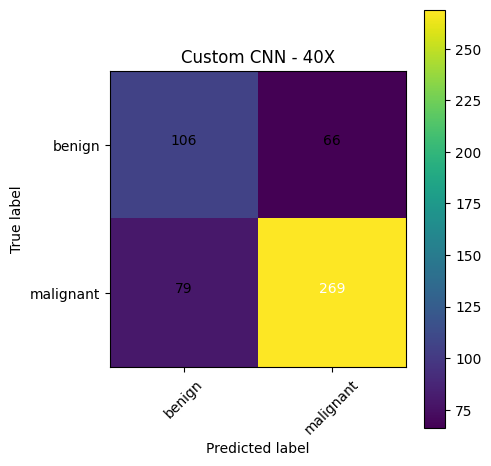

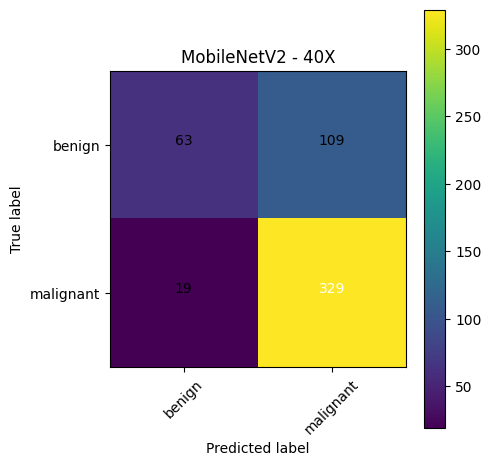

In [18]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
        plt.figure(figsize=(5,5))
        plt.imshow(cm, interpolation='nearest')
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()
plot_confusion_matrix(cm_custom, CLASS_NAMES, title=f'Custom CNN - {mag}')
plot_confusion_matrix(cm_mobilenet, CLASS_NAMES, title=f'MobileNetV2 - {mag}')

Custom CNN Training History (40X):


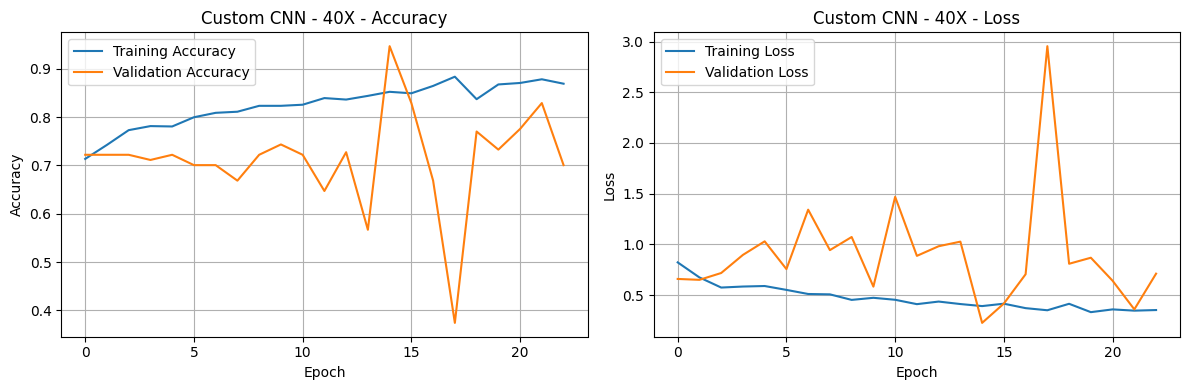

MobileNetV2 Training History (40X):


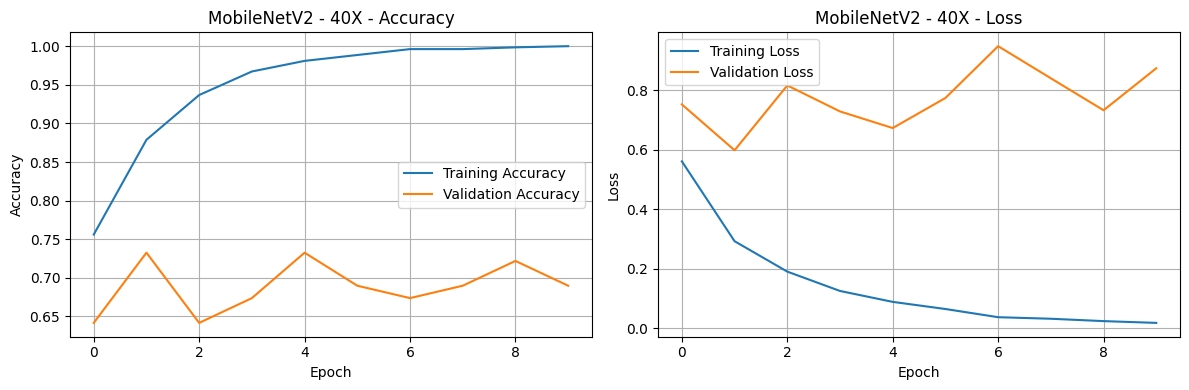

MobileNetV2 Fine-tuned Training History (40X):


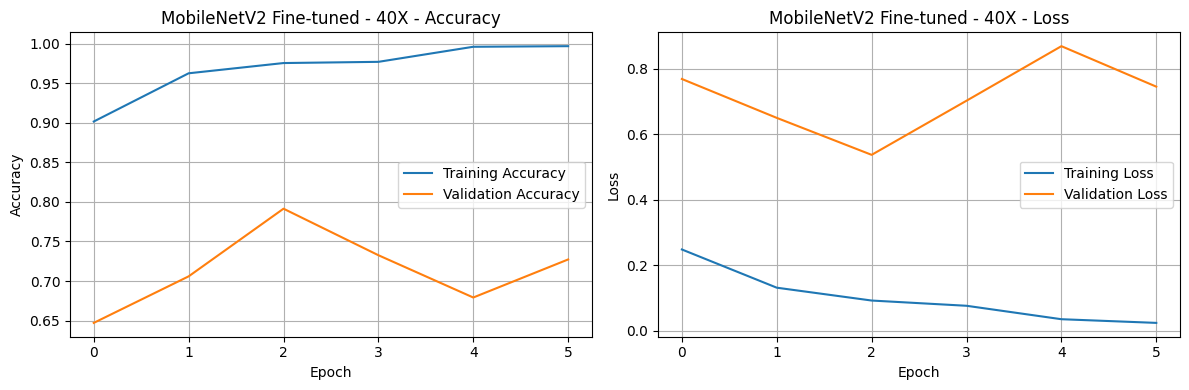

In [19]:
# Function to plot training history
def plot_training_history(history, model_name='Model'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot training & validation accuracy
        ax1.plot(history.history['accuracy'], label='Training Accuracy')
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title(f'{model_name} - Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Plot training & validation loss
        ax2.plot(history.history['loss'], label='Training Loss')
        ax2.plot(history.history['val_loss'], label='Validation Loss')
        ax2.set_title(f'{model_name} - Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
# Plot for Custom CNN
print(f"Custom CNN Training History ({mag}):")
plot_training_history(custom_history, f'Custom CNN - {mag}')
# Plot for MobileNetV2
print(f"MobileNetV2 Training History ({mag}):")
plot_training_history(mobilenet_history, f'MobileNetV2 - {mag}')
# Plot for MobileNetV2 Fine-tuned
print(f"MobileNetV2 Fine-tuned Training History ({mag}):")
plot_training_history(mobilenet_history_ft, f'MobileNetV2 Fine-tuned - {mag}')

In [20]:
# ===============================
# === Training for 200X Images ===
# ===============================

# Select 200X data
mag = '200X'
print(f"\n{'='*50}\nProcessing {mag}\n{'='*50}")
train_df = splits[mag]['train']
val_df = splits[mag]['val']
test_df = splits[mag]['test']
print("Verifying balanced splits:")
print(f"Training - Benign: {len(train_df[train_df['label'] == 'benign'])}, Malignant: {len(train_df[train_df['label'] == 'malignant'])}")
print(f"Validation - Benign: {len(val_df[val_df['label'] == 'benign'])}, Malignant: {len(val_df[val_df['label'] == 'malignant'])}")

# Create datasets - FIXED: Use enhanced function for validation
train_ds = df_to_tf_dataset(train_df, preprocess=None, training=True)
val_ds   = df_to_tf_dataset(val_df, preprocess=None, training=False)
test_ds  = df_to_tf_dataset(test_df, preprocess=None, training=False)

val_count = 0
for images, labels in val_ds:
    val_count += 1
print("Validation batches:", val_count)

print("\n Final verification:")
batch_classes = []
for images, labels in val_ds.take(3):  # Check multiple batches
    unique, counts = np.unique(labels.numpy(), return_counts=True)
    batch_classes.append(dict(zip(unique, counts)))
    print(f"Validation batch - Classes: {dict(zip(unique, counts))}")
print("Counts (200X):", len(train_df), len(val_df), len(test_df))

# Build and train custom cnn
custom_cnn_200 = build_custom_cnn()
history_cnn_200 = compile_and_train(custom_cnn_200, train_ds, val_ds, epochs=50, model_name=f'custom_cnn_{mag.lower()}')

# Build and train MobileNetV2 (transfer learning)
mobilenet_200 = build_mobilenet_v2(trainable_base=False)
mobilenet_200_history = compile_and_train(mobilenet_200, train_ds, val_ds, epochs=15, model_name=f'mobilenet_{mag.lower()}')
# Optional: unfreeze some layers and fine-tune
mobilenet_200.trainable = True
# Freeze first N layers if you want
for layer in mobilenet_200.layers[:-20]:
    layer.trainable = False
mobilenet_200_history_ft = compile_and_train(mobilenet_200, train_ds, val_ds, epochs=10, model_name=f'mobilenet_{mag.lower()}_finetuned', patience=3)


Processing 200X
Verifying balanced splits:
Training - Benign: 415, Malignant: 854
Validation - Benign: 55, Malignant: 163
Validation batches: 7

 Final verification:
Validation batch - Classes: {0: 32}
Validation batch - Classes: {0: 23, 1: 9}
Validation batch - Classes: {1: 32}
Counts (200X): 1269 218 526
Epoch 1/50


E0000 00:00:1761355451.383687      37 meta_optimizer.cc:966] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inStatefulPartitionedCall/enhanced_custom_cnn_1/dropout_16_1/stateless_dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step - accuracy: 0.7484 - loss: 0.6974
Epoch 1: val_loss improved from inf to 0.72199, saving model to custom_cnn_200x.weights.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 20s 314ms/step - accuracy: 0.7492 - loss: 0.6958 - val_accuracy: 0.5963 - val_loss: 0.7220 - learning_rate: 0.0010
Epoch 2/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step - accuracy: 0.7730 - loss: 0.5235
Epoch 2: val_loss improved from 0.72199 to 0.62800, saving model to custom_cnn_200x.weights.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 273ms/step - accuracy: 0.7739 - loss: 0.5225 - val_accuracy: 0.7477 - val_loss: 0.6280 - learning_rate: 9.9901e-04
Epoch 3/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step - accuracy: 0.8446 - loss: 0.4387
Epoch 3: val_loss improved from 0.62800 to 0.55779, saving model to custom_cnn_200x.weights.h5
40/40 ━━━━━━━━━━━━━━━━━━━━ 11s 268ms/step - accuracy: 0.8442 - loss: 0.4395 - val_accuracy: 0.7477 - val_loss: 0.5578 - learning_rate: 9.9606e-04
Epoch 4/50
40/40 ━━━━━━━━━━━━━━━━━━━━ 

In [21]:
def evaluate_and_report(model, df_test, preprocess=None):
        ds = df_to_tf_dataset(test_df, preprocess=None, training=False)
        preds = model.predict(ds)
        y_pred = np.argmax(preds, axis=1)
        y_true = [label_to_idx[l] for l in df_test['label'].values]
        print(classification_report(y_true, y_pred, target_names=CLASS_NAMES))
        cm = confusion_matrix(y_true, y_pred)
        return cm, y_true, y_pred
print(f"Custom CNN ({mag}) evaluation:")
cm_custom, y_true_custom, y_pred_custom = evaluate_and_report(custom_cnn_200, test_df)
print(f"MobileNet ({mag}) evaluation:")
cm_mobilenet, y_true_mob, y_pred_mob = evaluate_and_report(mobilenet_200, test_df, preprocess=mobilenet_preprocess)

Custom CNN (200X) evaluation:
17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 214ms/step
              precision    recall  f1-score   support

      benign       0.40      0.75      0.52       153
   malignant       0.84      0.54      0.66       373

    accuracy                           0.60       526
   macro avg       0.62      0.64      0.59       526
weighted avg       0.71      0.60      0.62       526

MobileNet (200X) evaluation:
17/17 ━━━━━━━━━━━━━━━━━━━━ 10s 415ms/step
              precision    recall  f1-score   support

      benign       0.63      0.56      0.60       153
   malignant       0.83      0.87      0.85       373

    accuracy                           0.78       526
   macro avg       0.73      0.71      0.72       526
weighted avg       0.77      0.78      0.77       526



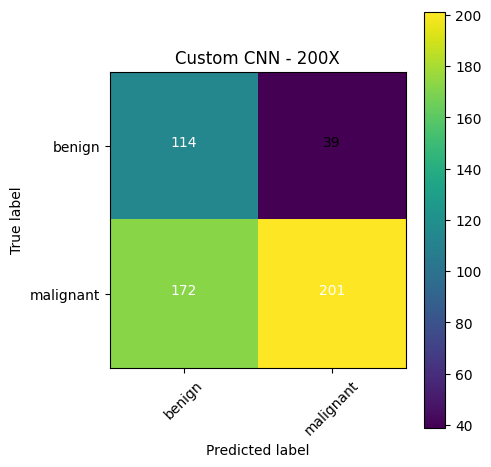

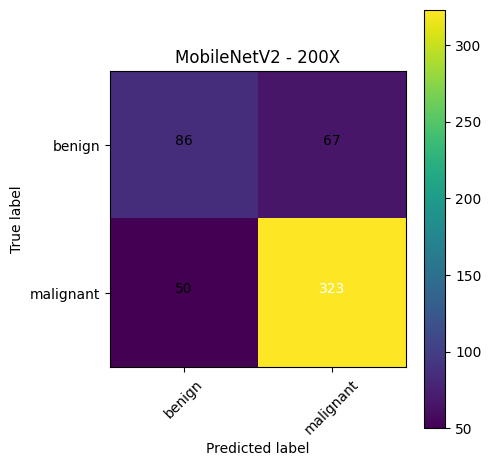

In [22]:
def plot_confusion_matrix(cm, classes, title='Confusion matrix'):
        plt.figure(figsize=(5,5))
        plt.imshow(cm, interpolation='nearest')
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        fmt = 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.tight_layout()
        plt.show()
plot_confusion_matrix(cm_custom, CLASS_NAMES, title=f'Custom CNN - {mag}')
plot_confusion_matrix(cm_mobilenet, CLASS_NAMES, title=f'MobileNetV2 - {mag}')

Custom CNN Training History (200X):


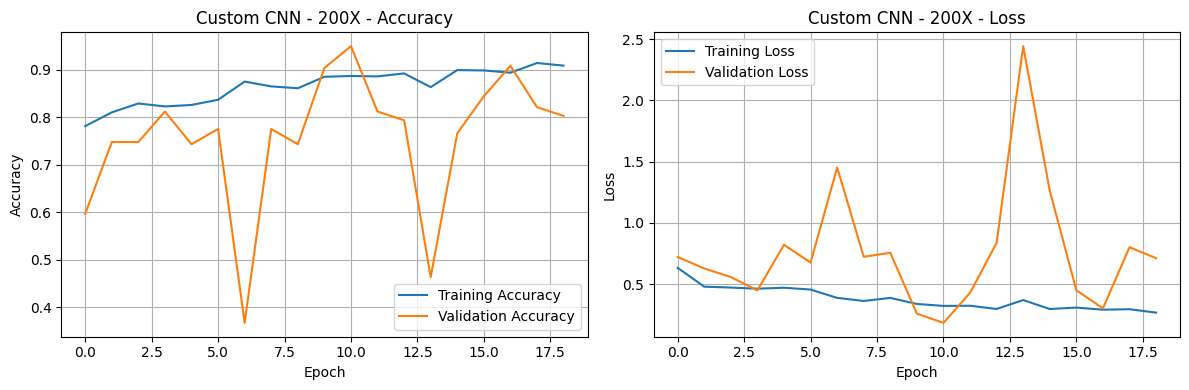

MobileNetV2 Training History (200X):


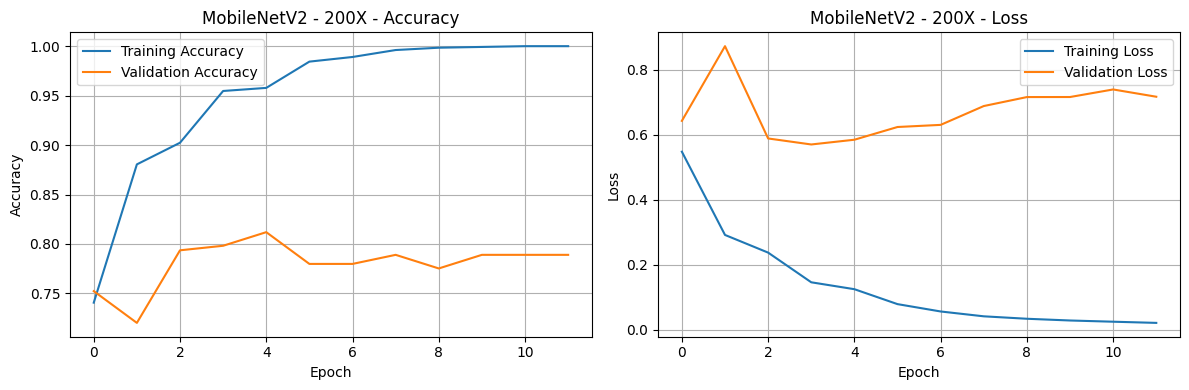

MobileNetV2 Fine-tuned Training History (200X):


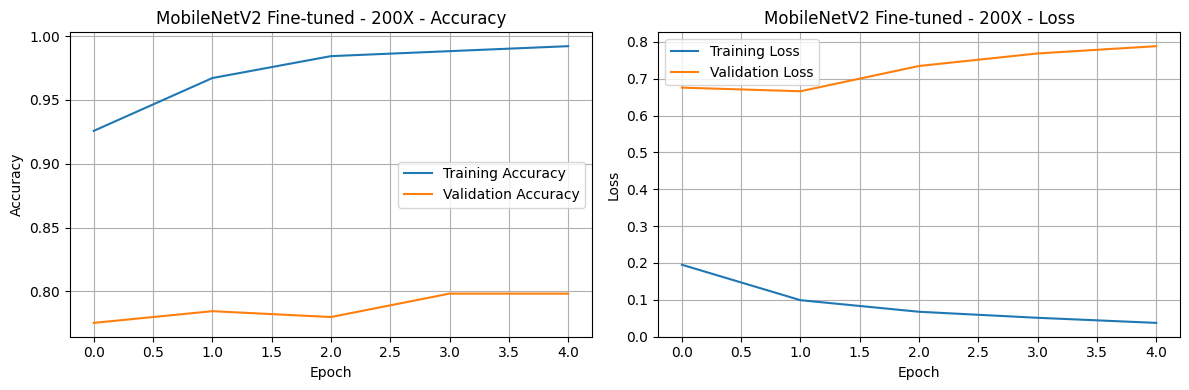

In [23]:
def plot_training_history(history, model_name='Model'):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
        
        # Plot training & validation accuracy
        ax1.plot(history.history['accuracy'], label='Training Accuracy')
        ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
        ax1.set_title(f'{model_name} - Accuracy')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Accuracy')
        ax1.legend()
        ax1.grid(True)
        
        # Plot training & validation loss
        ax2.plot(history.history['loss'], label='Training Loss')
        ax2.plot(history.history['val_loss'], label='Validation Loss')
        ax2.set_title(f'{model_name} - Loss')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Loss')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
# Plot for Custom CNN
print(f"Custom CNN Training History ({mag}):")
plot_training_history(history_cnn_200, f'Custom CNN - {mag}')
# Plot for MobileNetV2
print(f"MobileNetV2 Training History ({mag}):")
plot_training_history(mobilenet_200_history, f'MobileNetV2 - {mag}')
# Plot for MobileNetV2 Fine-tuned
print(f"MobileNetV2 Fine-tuned Training History ({mag}):")
plot_training_history(mobilenet_200_history_ft, f'MobileNetV2 Fine-tuned - {mag}')